In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchlens as tl # a library to get activations from network
import numpy as np


# Understanding Grokking through Correlation Structure

Adam Shai, 2023.03.05
adamimos@gmail.com

This work follows up on the transformer grokking work, focussing on the example of modular addition in a 1 layer transformer network. 
I want to study the correlation structure between the activations in the network across the different possible inputs. This example is useful
because we can easily enumerate all the different possible inputs and get the network activations completely.

The correlation analysis is inspired by work in neuroscience analysing information processing and sensory representation, especially in the cortex, in large populations of neurons (in neuroscience large means ~100-10,000 neurons). There are a number of interesting things to say about the situation in neuroscience vs. deep learning and the use of studying correlations, but I'll leave that for another time.

Let's see if we can get a handle on grokking through studying correlation structure!

## Why study correlation structure?

When trying to think about the computation a network carries out, it is natural to think of the architecture, and how that architecture relates to an algorithm that carries out a specified computation. After all, it is the architecture that changes over learning. However, there is a sense in which it is the activations in a network that really carry out the computation. From this point of view, learning is the process of changing the network architecture in order to organize the neuron activations in such a way that they carry out the desired computation. Thus, it seems desireable to study the organization of activations in a network.

But what does "organization of activations" actually mean mathematically? We can think of neural activations in response to a particular input as living in an N-dimensional space, where N is the number of neurons in the network, and the activation of each neuron is a dimension. The activations in response to a particular input are a point in this space. This simple setup allows us to use a number of tools from linear algebra and geometry to study the organization of the activations.

For instance, we can ask how many linear dimensions are needed to capture most of the variance in the activations, in response to a particular set of inputs (for instance, the training set, or the validation set, or over all the possible inputs), and see how this changes over time. A result of this type of analysis might find that over training, activations become more and more concentrated in a low dimensional subspace, which might suggest that the network is learning to represent the input in a more efficient way, or that this is only true after generalization has occured, or that this occurs for some set of inputs but not others, etc. Results here might shed light on the nature of memorization and generalization in neural networks. In general, this type of analysis is carried out using principal component analysis (PCA).

We can similarly ask questions about the relationship between the activations to a set of inputs between two different networks, or between two different parts or layers in the same network. This type of analysis tells us about how the structure of activations in one part of a network relates to the structure in some other part. Do two parts of a network "sync up" over training, are there different subnetworks that account for global coordination vs. local computations? This type of analysis is carried out using canonical correlation analysis (CCA).

## Relationships to neuroscience

## Some findings here

In the plots that follow you will find the following:
1.

## Recreating the grokking results for modular addition

Below is my code to recreate the results of the grokking work for modular addition. We save the state of the network every 10 epochs during training. We get nice grokking results. We've saved all the data in `training_dict.pt` if you don't want to train from scratch. It took ~15 minutes using my GPU.

### Network, training, and data hyperparameters

In [2]:
 # we are going to do modular addition
# our task is to take inputs a,b \in {0,...,P-1} for some prime P and predict a+b mod P, call the result c
# input is of the form "a b = c"
# hyperparameters
P = 113 # the prime number
d_vocab = P+2 # the size of the vocabulary, add one for = sign, of which there will be 2
d_model = 128 # the width of the residual streal (embedding dimension)
d_head = 32 # the width of each head, 4 of them
d_mlp = 512 # the width of the feed forward layer
input_size = 3 # the length of the context, a, b, and =

# training params
training_percent = 0.4
learning_rate = 0.001
lam = 1.
epochs = 40000

# generate all possible a,b,c triples, there should be 113*113 of them
# we will use these to train the model
# keep these all in a torch tensor of size (113*113, 4)
torch.manual_seed(0)
triples = torch.zeros((2*P*P, 4), dtype=torch.long)
for i in range(P):
    for j in range(P):
        triples[i*P+j, 0] = i
        triples[i*P+j, 1] = j
        triples[i*P+j, 2] = P
        triples[i*P+j, 3] = (i+j)%P

# now let's add some more rows, for subtraction
# we will add 113*113 more rows
# these will be of the form "a b = c" where c = a-b mod P
for i in range(P):
    for j in range(P):
        triples[P*P+i*P+j, 0] = i
        triples[P*P+i*P+j, 1] = j
        triples[P*P+i*P+j, 2] = P+1
        triples[P*P+i*P+j, 3] = (i-j)%P

# use 30% of the data for training, 70% for validation
# randomly choose the 30 percent
train_size = int(training_percent*len(triples))
data_size = len(triples)
inds = torch.randperm(data_size)
train_indices = inds[:train_size]
val_indices = inds[train_size:]
train_data = triples[train_indices]
val_data = triples[val_indices]

# make sure theres no overlap between train and val
assert len(set(train_indices).intersection(set(val_indices))) == 0

print("the number of training examples is", len(train_data))
print("the number of validation examples is", len(val_data))
print("total number of examples is", len(train_data)+len(val_data))
print("here are some examples of training data")
print(train_data[:10])


the number of training examples is 10215
the number of validation examples is 15323
total number of examples is 25538
here are some examples of training data
tensor([[ 37,   1, 113,  38],
        [ 44,  72, 113,   3],
        [ 20,   2, 114,  18],
        [ 78,  40, 114,  38],
        [ 68,  91, 113,  46],
        [ 21,  50, 113,  71],
        [ 44, 104, 114,  53],
        [ 93, 102, 113,  82],
        [ 82,  79, 113,  48],
        [ 18,  86, 114,  45]])


### The Simple Transformer

This should be pretty straightforward. Hopefully I didn't mess anything up! At least it seems to learn.

In [3]:
class Head(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.W_Q = nn.Linear(d_model, d_head, bias=False)
        self.W_K = nn.Linear(d_model, d_head, bias=False)
        self.W_V = nn.Linear(d_model, d_head, bias=False)
        self.W_O = nn.Linear(d_head, d_head, bias=False)
        self.register_buffer("mask", torch.tril(torch.ones(input_size, input_size)))

    def forward(self, x):
        # x is of size (batch_size, input_size, d_model)
        # get the query, key, and value
        Q = self.W_Q(x) # (batch_size, input_size, d_head)
        K = self.W_K(x) # (batch_size, input_size, d_head)
        V = self.W_V(x) # (batch_size, input_size, d_head)
        # get the attention weights
        A = torch.einsum("bid,bjd->bij", Q, K) / (d_head**0.5) 
        A = A.masked_fill(self.mask==0, float("-inf"))
        A = F.softmax(A, dim=-1) # the rows of A sum to 1
        # apply the attention weights
        O = torch.einsum("bij,bjd->bid", A, V) # this is the output of the attention head, we weight the values by the attention weights
        O = self.W_O(O) # (batch_size, input_size, d_model)
        return O 
    
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp):
        super().__init__()
        self.W_in = nn.Linear(d_model, d_mlp)
        self.W_out = nn.Linear(d_mlp, d_model)
        
    def forward(self, x):
        # x is of size (batch_size, input_size, d_model)
        x = self.W_in(x) # (batch_size, input_size, d_mlp)
        x = F.relu(x)
        x = self.W_out(x) # (batch_size, input_size, d_model)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(d_vocab, d_model)
        self.pos_embedding = nn.Embedding(input_size, d_model)
        self.heads = nn.ModuleList([Head(d_head) for _ in range(4)])
        self.mlp = MLP(d_model, d_mlp)
        self.unembedding = nn.Linear(d_model, d_vocab)

    def forward(self, x):
        # x is of size (batch_size, input_size)
        # embed the input
        x = self.embedding(x) + self.pos_embedding(torch.arange(input_size, device=x.device))
        # apply the attention heads, stack them
        x = x + torch.cat([head(x) for head in self.heads], dim=-1) # (batch_size, input_size, d_model)
        # apply the MLP
        x = x + self.mlp(x)
        # unembed the output
        x = self.unembedding(x)
        return x


### Training
Change the `TRAIN` variable to True if you want to rerun training

In [4]:
TRAIN = True
import copy

# make a training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

# train on all the training data
x = train_data[:, :input_size].to(device)
y = train_data[:, -input_size:].to(device) # (batch_size, input_size)

x_val = val_data[:, :input_size].to(device)
y_val = val_data[:, -input_size:].to(device) # (batch_size, input_size)

# make a function that evaluates the loss on both the training and validation data
@torch.no_grad()
def evaluate_loss(model):
    model.eval()
    # training data
    logits = model(x) # (batch_size, input_size, d_vocab)
    logits, y_last = logits[:, -1], y[:, -1] # (batch_size, d_vocab), (batch_size,)
    train_loss = F.cross_entropy(logits, y_last, reduction="mean")
    train_acc = (torch.argmax(logits, dim=-1) == y_last).float().mean()
    # validation data
    logits = model(x_val) # (batch_size, input_size, d_vocab)
    logits, y_val_last = logits[:, -1], y_val[:, -1] # (batch_size, d_vocab), (batch_size,)
    val_loss = F.cross_entropy(logits, y_val_last, reduction="mean")
    val_acc = (torch.argmax(logits, dim=-1) == y_val_last).float().mean()
    model.train() # put the model back in training mode
    return train_loss, train_acc, val_loss, val_acc

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=lam)#, betas = (0.9, 0.98))

if TRAIN:
    # a dictionary to store the training and validation losses
    training_dict = {}
    training_dict["train_data"] = train_data
    training_dict["val_data"] = val_data
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        # get the predictions
        preds = model(x) # (batch_size, input_size, d_vocab)
        # we only care about the last prediction
        preds = preds[:, -1] # (batch_size, d_vocab)
        y_last = y[:, -1] # (batch_size,)
        loss = F.cross_entropy(preds, y_last, reduction="mean")
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        # print the loss and epoch
        if epoch%10==0:
            train_loss, train_acc, val_loss, val_acc = evaluate_loss(model)
            # print the loss and accuracy, with two decimal places, add to the pbar
            pbar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.8f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            # keep track of these values in a dictionary
            # add learning rat to end of pbar
            pbar.set_postfix({"lr": optimizer.param_groups[0]["lr"]})
            training_dict[epoch] = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
            # add the model parameters to the training dict, deepcopy to avoid memory issues
            training_dict[epoch]["model"] = copy.deepcopy(model.state_dict())


    # save the training dict
    torch.save(training_dict, "training_dict_addition_subtraction.pt")

        


  0%|          | 0/40000 [00:00<?, ?it/s]

In [5]:
# get the embedding matrix
embedding_matrix = model.embedding.weight.detach().cpu().numpy()

# get the output of the mlp
mlp_output = model.mlp.W_out.weight.detach().cpu().numpy()

# get the output of the unembedding layer
unembedding_matrix = model.unembedding.weight.detach().cpu().numpy()

# print the shape of each of these
print(embedding_matrix.shape)
print(mlp_output.shape)
print(unembedding_matrix.shape)

(115, 128)
(128, 512)
(115, 128)


In [6]:
model

Model(
  (embedding): Embedding(115, 128)
  (pos_embedding): Embedding(3, 128)
  (heads): ModuleList(
    (0-3): 4 x Head(
      (W_Q): Linear(in_features=128, out_features=32, bias=False)
      (W_K): Linear(in_features=128, out_features=32, bias=False)
      (W_V): Linear(in_features=128, out_features=32, bias=False)
      (W_O): Linear(in_features=32, out_features=32, bias=False)
    )
  )
  (mlp): MLP(
    (W_in): Linear(in_features=128, out_features=512, bias=True)
    (W_out): Linear(in_features=512, out_features=128, bias=True)
  )
  (unembedding): Linear(in_features=128, out_features=115, bias=True)
)

### Load the training results

In [7]:
# clear cuda memory
torch.cuda.empty_cache()

# load training dict .pt file
training_dict = torch.load("training_dict_addition_subtraction.pt")
# move everything in the training dictionary to the cpu
# the structure of the training dict is:
# training_dict[epoch] = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
# training_dict[epoch]["model"] = model.state_dict()
for epoch in training_dict:
    if type(epoch) == int:
        for key in training_dict[epoch]:
            if type(training_dict[epoch][key]) == torch.Tensor:
                training_dict[epoch][key] = training_dict[epoch][key].cpu()

# get the training and validation data
train_data = training_dict["train_data"] # (batch_size, input_size)
val_data = training_dict["val_data"] # (batch_size, input_size)


### We see Grokking!

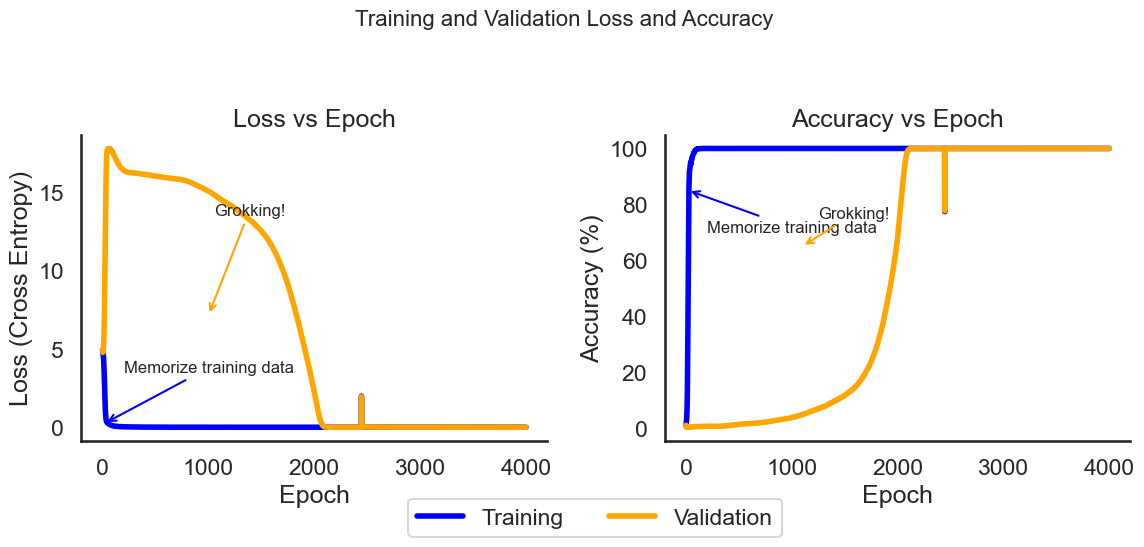

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

train_loss = [training_dict[epoch]["train_loss"] for epoch in training_dict if type(epoch) == int]
val_loss = [training_dict[epoch]["val_loss"] for epoch in training_dict if type(epoch) == int]
train_acc = [100*training_dict[epoch]["train_acc"] for epoch in training_dict if type(epoch) == int]
val_acc = [100*training_dict[epoch]["val_acc"] for epoch in training_dict if type(epoch) == int]
# lambda function for the above


sns.set_style("white")
sns.set_context("talk")

# plot the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.suptitle("Training and Validation Loss and Accuracy", fontsize=16, y=1.05)

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training", linewidth=4, color='blue')
plt.plot(val_loss, label="Validation", linewidth=4, color='orange')
#plt.xlim([0, 1500])
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy)")
plt.title("Loss vs Epoch")

# Add an arrow for memorize training data
plt.annotate("Memorize training data", xy=(20, 0.25), xytext=(200, 3.5), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="blue", arrowstyle="->"))

plt.annotate("Grokking!", xy=(1000, 7.15), xytext=(1050, 13.5), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="orange", arrowstyle="->"))

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training", linewidth=4, color='blue')
plt.plot(val_acc, label="Validation", linewidth=4, color='orange')
#plt.xlim([0, 1500])

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
sns.despine()

# Add an arrow for grokking
plt.annotate("Memorize training data", xy=(20, 85), xytext=(200, 70), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="blue", arrowstyle="->"))

plt.annotate("Grokking!", xy=(1100, 65), xytext=(1250, 75), fontsize=12,
             arrowprops=dict(facecolor="black", edgecolor="orange", arrowstyle="->"))

plt.tight_layout()
# Place the legend at the center underneath both plots with two columns
plt.legend(["Training", "Validation"], bbox_to_anchor=(-0.15, -0.15), loc="upper center", ncol=2)
plt.show()

# Estimate where memorization of the training data and grokking occur

In [11]:
# function to find absolute value of max difference
abs_argmax = lambda x: np.argmax(np.abs(np.diff(x)))

mem_loss_epoch = abs_argmax(train_loss[0:1500])
grok_loss_epoch = abs_argmax(val_loss[500:1500])+500

mem_acc_epoch = abs_argmax(train_acc[0:1500])
grok_acc_epoch = abs_argmax(val_acc[0:1500])

print(f"Memorization")
print(f"------------------")
print(f"Memorize loss epoch: {mem_loss_epoch}")
print(f"Memorize acc epoch: {mem_acc_epoch}")
print(f"\n")
print(f"Grokking")
print(f"------------------")
print(f"Grok acc epoch: {grok_acc_epoch}")
print(f"Grok loss epoch: {grok_loss_epoch}")

Memorization
------------------
Memorize loss epoch: 12
Memorize acc epoch: 13


Grokking
------------------
Grok acc epoch: 1070
Grok loss epoch: 1054


Incredibly, the network memorizes the training data after only a dozen epochs or so, and yet it takes more than 1000 more epochs for the test set accuracy to budge much beyond 0. **What is happening in the network over this time?**

# Diagram of the model archetecture, with the names of the different parts of the transformer
In order to use torchlens to get activations from the network we need to know the names of the different modules in the network. Here is a diagram of the network with the names of the different modules.

c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\torchlens\torch_decorate.py:193: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  attr = getattr(input_tensor, attr_name)


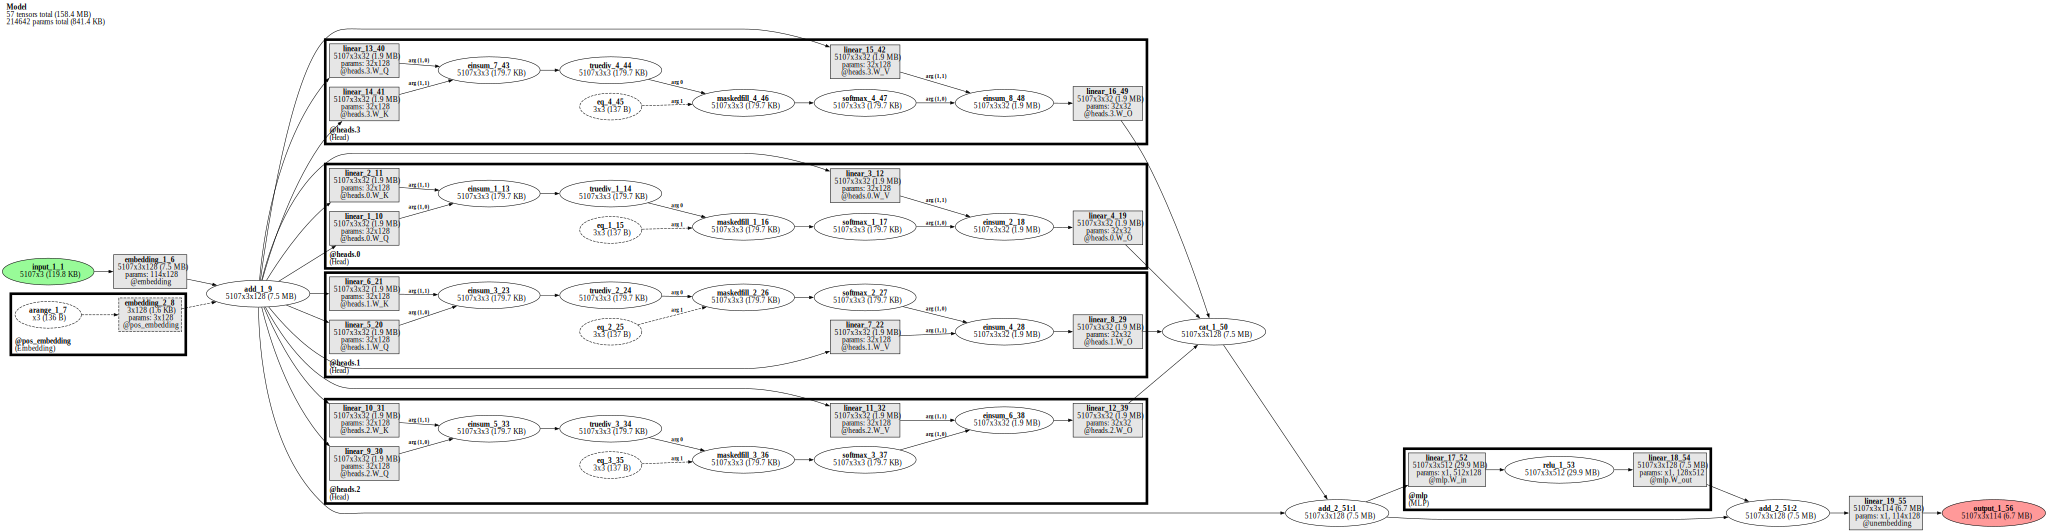

In [12]:
# get the layers for the model
model = Model().to(device)
tl.show_model_graph(model, x, vis_direction="horizontal")

# Get activations over learning

In [13]:
"""
Load a trained neural network model from a training dictionary and extract the activations of all its layers on a given dataset. The resulting activations are stored in a dictionary with keys representing epochs.

Args:
    training_dict (dict): a dictionary containing information about the trained model, including the model's state_dict at various epochs
    x (torch.Tensor): the input dataset to extract activations from
    x_val (torch.Tensor): the validation dataset to extract activations from
    device (str): the device to use for computation, either 'cpu' or 'cuda'

Returns:
    dict: a dictionary of activations for each epoch, with keys representing epochs and values containing the activations of each layer of the neural network model for the given dataset.

Note that the code uses a `torchlens` library to extract the activations of all layers of the neural network model.    
"""


# print all the avaialble epochs in the training dict, we are only interested in epochs up to a value of 15000
epochs = [epoch for epoch in training_dict if type(epoch) == int and epoch <= 2000]
# only keep epochs that are divisible by 1000
epochs = [epoch for epoch in epochs if epoch%50==0]

# loop through each of the epochs and get the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pbar = tqdm(epochs)
W_E = {} # dictionary to store activations
device = "cpu"

train_len = len(train_data)
val_len = len(val_data)
all_data = torch.cat([train_data, val_data], dim=0)

# Add a fifth column that is 0 for train data and 1 for val data
col5 = torch.cat([torch.zeros(train_len), torch.ones(val_len)], dim=0)
all_data = torch.cat([all_data, col5.unsqueeze(1)], dim=1)

# Sort the data first by the second column, then by the first column
sorted_indices = np.lexsort((all_data[:, 1].numpy(), all_data[:, 0].numpy()))
all_data = all_data[sorted_indices]

train_inds = torch.where(all_data[:, 4] == 0)[0]
val_inds = torch.where(all_data[:, 4] == 1)[0]

# first 3 columns
x = all_data[:, 0:3].int()

for epoch in pbar:
    model = Model().to(device)
    model.load_state_dict(training_dict[epoch]["model"])
    model.eval()
    acts = tl.get_model_activations(model, x, which_layers='all')
    W_E[epoch] = acts
    del model
    


  0%|          | 0/41 [00:00<?, ?it/s]

c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\torchlens\model_history.py:2630: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  attr = getattr(t, attr_name)
c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\torchlens\model_history.py:2630: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() 

In [14]:
from typing import Union, List

trial_types = ['all', 'train', 'val']
model_parts = {'attn_softmax': ['softmax_4_47', 'softmax_1_17', 'softmax_2_27', 'softmax_3_37'],
              'mlp_relu': 'relu_1_53',
              'embed': 'add_1_9',
              'attn_out': 'cat_1_50',
              'mlp_out': 'linear_18_54'}

def get_activations(part: Union[str, List[str]], epoch: int, trial_type: str = None) -> np.ndarray:
    if isinstance(part, list):
        layer_acts = []
        for layer_name in part:
            single_head = W_E[epoch][layer_name].tensor_contents
            # add another dimension in position 1
            single_head = np.expand_dims(single_head, axis=1)
            layer_acts.append(single_head)
        # concatenate activations across a new axis
        layer_acts = np.concatenate(layer_acts, axis=1) 
    else:
        layer_name = part
        layer_acts = W_E[epoch][layer_name].tensor_contents

    if trial_type == 'train':
        inds = train_inds
        layer_acts = layer_acts[inds]
    elif trial_type == 'val':
        inds = val_inds
        layer_acts = layer_acts[inds]

    if epoch == 0:
        print("size of activations is:", layer_acts.shape)

    return layer_acts



The shape of the attention softmax activations is: (12769, 4, 3, 3), representing (n_trials, n_heads, source, destination)
The shape of the mean attention softmax activations is: (4, 3, 3), representing (n_heads, source, destination)


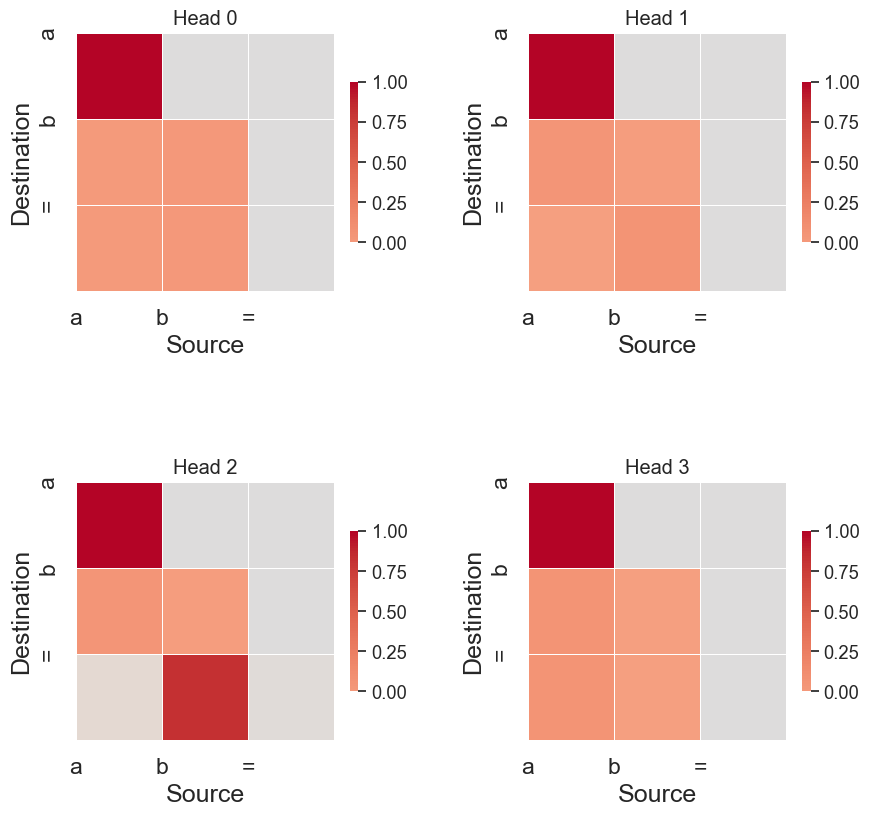

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm, ListedColormap

# Retrieve attention pattern activations
attn_softmax_acts = get_activations(model_parts['attn_softmax'], 2000, 'all')
print(f"The shape of the attention softmax activations is: {attn_softmax_acts.shape}, representing (n_trials, n_heads, source, destination)")

# Compute the mean attention pattern for each head, averaged across all trials
mean_attn_softmax_acts = attn_softmax_acts.mean(axis=0)
print(f"The shape of the mean attention softmax activations is: {mean_attn_softmax_acts.shape}, representing (n_heads, source, destination)")

# Plot the mean attention pattern for each head
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

# Set plot aesthetics
sns.set(style="white", context="notebook", font_scale=1.2)

# Create a custom color map
cmap = ListedColormap(sns.color_palette("coolwarm", n_colors=256))

labels = ["a", "b", "="]

for head in range(4):
    ax = axes[head]
    sns.heatmap(mean_attn_softmax_acts[head], cmap=cmap, square=True, linewidths=.5, vmin=-1, vmax=1, cbar_kws={"shrink": .5}, ax=ax, norm=TwoSlopeNorm(0))

    ax.set_title(f"Head {head}")
    ax.set_xticks(range(3))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Source")
    ax.set_yticks(range(3))
    ax.set_yticklabels(labels)
    ax.set_ylabel("Destination")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


The shape of the attention softmax activations is: (12769, 4, 3, 3), representing (n_trials, n_heads, source, destination)


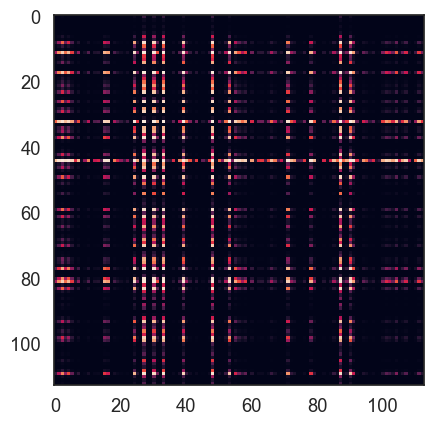

In [17]:
# lets look at the activations over all possible values of the inputs
# Retrieve attention pattern activations
attn_softmax_acts = get_activations(model_parts['attn_softmax'], 2000, 'all')
print(f"The shape of the attention softmax activations is: {attn_softmax_acts.shape}, representing (n_trials, n_heads, source, destination)")
plt.imshow(attn_softmax_acts[:, 2, -1, 0].reshape(113,113))

The shape of the attention softmax activations is: torch.Size([12769, 3, 512]), representing (n_trials, token, mlp_dim)


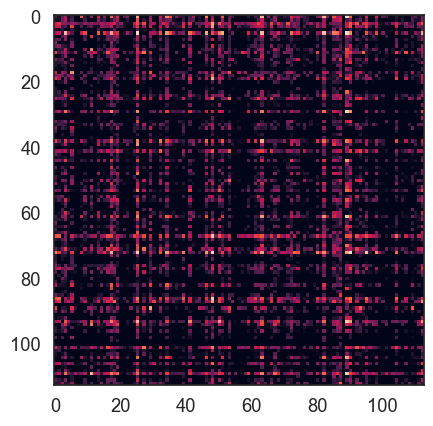

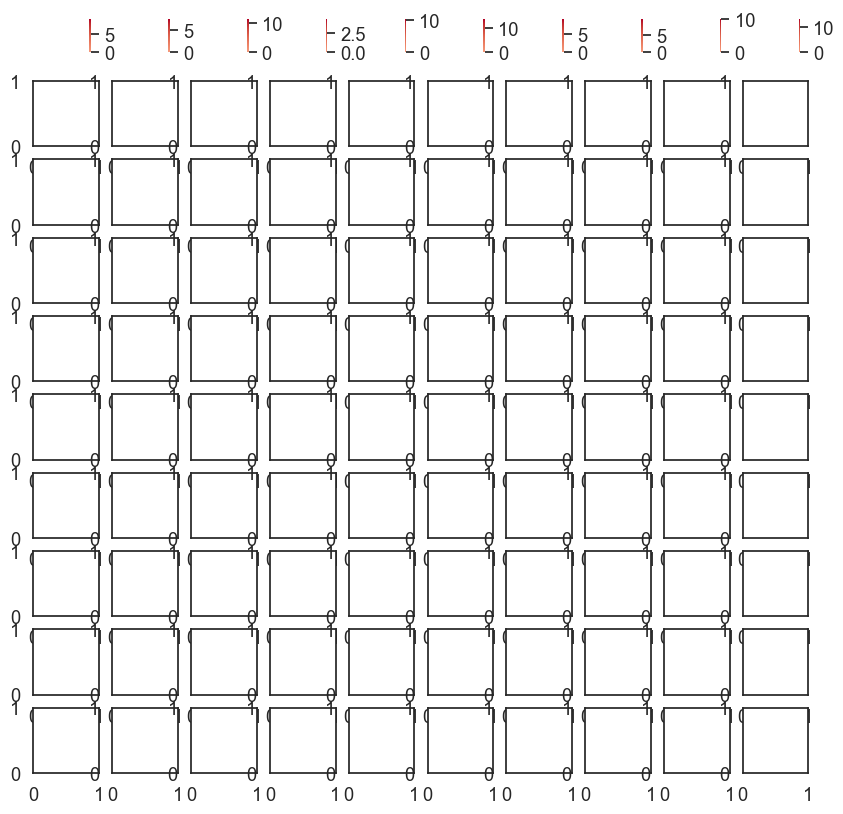

In [18]:
mlp_relu_acts = get_activations(model_parts['mlp_relu'], 2000, 'all')
print(f"The shape of the attention softmax activations is: {mlp_relu_acts.shape}, representing (n_trials, token, mlp_dim)")
      
nrn = 1
plt.imshow(mlp_relu_acts[:, -1, nrn].reshape(113,113))

# do this in a 10 by 10 grid for 100 neurons
fig, axes = plt.subplots(5, 10, figsize=(10, 10))
axes = axes.ravel()

# Set plot aesthetics
sns.set(style="white", context="notebook", font_scale=1.2)

# Create a custom color map
cmap = ListedColormap(sns.color_palette("coolwarm", n_colors=256))

labels = ["a", "b", "="]

for nrn in range(10):
    ax = axes[nrn]
    sns.heatmap(mlp_relu_acts[:, -1, nrn].reshape(113,113), cmap=cmap, square=True, linewidths=.5, vmin=-1, vmax=1, cbar_kws={"shrink": .5}, ax=ax, norm=TwoSlopeNorm(0))
    # get rid of x and y labels
    ax.set_xticks([])
    ax.set_yticks([])


# Compute covariance matrix (do PCA)

## get all the activations over training over all possible inputs

In [18]:
from typing import Dict, Tuple
from typing import List, Union

def get_activations(part: Union[str, List[str]], epoch: int, trial_type: str = None) -> np.ndarray:
    """
    Retrieve activations for the specified part of the model.

    Args:
        part (Union[str, List[str]]): Model part ('embed', 'attn_out', or 'mlp_out') or a list of layer names.
        epoch (int): Epoch number.
        trial_type (str, optional): Trial type ('train', 'val', or None). Defaults to None.

    Returns:
        np.ndarray: Activations for the specified part of the model. Shape: (num_trials, input_size, d_model).
    """

    if isinstance(part, list):
        layer_acts = []
        for layer_name in part:
            layer_acts.append(W_E[epoch][layer_name].tensor_contents)
        layer_acts = np.concatenate(layer_acts, axis=1)
    else:
        layer_name = part
        layer_acts = W_E[epoch][layer_name].tensor_contents

    if trial_type == 'train':
        inds = train_inds
        layer_acts = layer_acts[inds]
    elif trial_type == 'val':
        inds = val_inds
        layer_acts = layer_acts[inds]

    if epoch == 0:
        print("size of activations is:", layer_acts.shape)

    return layer_acts



def normalize_activations(activations: np.ndarray) -> np.ndarray:
    """
    Normalize activations by z-scoring.

    Args:
        activations (np.ndarray): Model activations.

    Returns:
        np.ndarray: Normalized activations. 
    """

    normalized_acts = (activations - activations.mean(axis=0)) / activations.std(axis=0)
    normalized_acts[np.isnan(normalized_acts)] = 0
    normalized_acts[np.isinf(normalized_acts)] = 0

    return normalized_acts


def compute_covariance_and_variance_explained(activations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute covariance matrix and variance explained per principal component.

    Args:
        activations (np.ndarray): Model activations. 

    Returns:
        Tuple[np.ndarray, np.ndarray]: Covariance matrix and variance explained.
    """

    covs = np.cov(activations, rowvar=False)
    var_expl = np.linalg.svd(covs, compute_uv=False)
    var_expl = var_expl / np.sum(var_expl)

    return covs, var_expl


def get_covs_and_var_expl(part: str, epoch: int, trial_type: str = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get covariance matrix and variance explained for the specified part of the model.

    Args:
        part (str): Model part ('embed', 'attn_out', or 'mlp_out').
        epoch (int): Epoch number.
        trial_type (str, optional): Trial type ('train', 'val', or None). Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Covariance matrix and variance explained.
    """

    activations = get_activations(part, epoch, trial_type)
    trials, input_size, d_model = activations.shape
    n_neurons = input_size * d_model
    activations = activations.reshape(trials, n_neurons)
    activations = normalize_activations(activations)
    covs, var_expl = compute_covariance_and_variance_explained(activations)

    return covs, var_expl


def get_covs_and_var_expl_all_epochs(part: str, trial_type: str = None) -> Tuple[Dict[int, np.ndarray], Dict[int, np.ndarray]]:
    """
    Get covariance matrix and variance explained for all epochs.

    Args:
        part (str): Model part ('embed', 'attn_out', or 'mlp_out').
        trial_type (str, optional): Trial type ('train', 'val', or None). Defaults to None.

    Returns:
        Tuple[Dict[int, np.ndarray], Dict[int, np.ndarray]]: Covariance matrices and variance explained for all epochs.
    """

    epochs = [epoch for epoch in W_E]
    cov_dict = {}
    var_dict = {}

    for epoch in epochs:
        cov, var = get_covs_and_var_expl(part, epoch, trial_type)
        cov_dict[epoch] = cov
        var_dict[epoch] = var

    return cov_dict, var_dict

trial_types = ['all', 'train', 'val']
model_part = {'attn_softmax': ['softmax_4_47', 'softmax_1_17', 'softmax_2_27', 'softmax_3_37'],
              'mlp_relu': 'relu_1_53'}
covs = {}
var_expl = {}

for trial_type in trial_types:
    covs[trial_type] = {}
    var_expl[trial_type] = {}
    print("trial type is:", trial_type)
    for mp in model_part:
        print("model part is:", mp)
        covs[trial_type][mp], var_expl[trial_type][mp] = get_covs_and_var_expl_all_epochs(model_part[mp], trial_type)



trial type is: all
model part is: attn_softmax
size of activations is: (12769, 12, 3)


C:\Users\adamimos\AppData\Local\Temp\ipykernel_41724\3624514042.py:51: RuntimeWarning: invalid value encountered in divide
  normalized_acts = (activations - activations.mean(axis=0)) / activations.std(axis=0)


model part is: mlp_relu
size of activations is: torch.Size([12769, 3, 512])


C:\Users\adamimos\AppData\Local\Temp\ipykernel_41724\3624514042.py:52: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1773.)
  normalized_acts[np.isnan(normalized_acts)] = 0
C:\Users\adamimos\AppData\Local\Temp\ipykernel_41724\3624514042.py:53: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1773.)
  normalized_acts[np.isinf(normalized_acts)] = 0


trial type is: train
model part is: attn_softmax
size of activations is: (5107, 12, 3)
model part is: mlp_relu
size of activations is: torch.Size([5107, 3, 512])
trial type is: val
model part is: attn_softmax
size of activations is: (7662, 12, 3)
model part is: mlp_relu
size of activations is: torch.Size([7662, 3, 512])


## Do PCA

C:\Users\adamimos\AppData\Local\Temp\ipykernel_41724\1492493917.py:15: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[i, j].get_shared_y_axes().join(axs[i, j], axs[i, 0])
C:\Users\adamimos\AppData\Local\Temp\ipykernel_41724\1492493917.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[i, j].get_shared_x_axes().join(axs[i, j], axs[0, j])
C:\Users\adamimos\AppData\Local\Temp\ipykernel_41724\1492493917.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


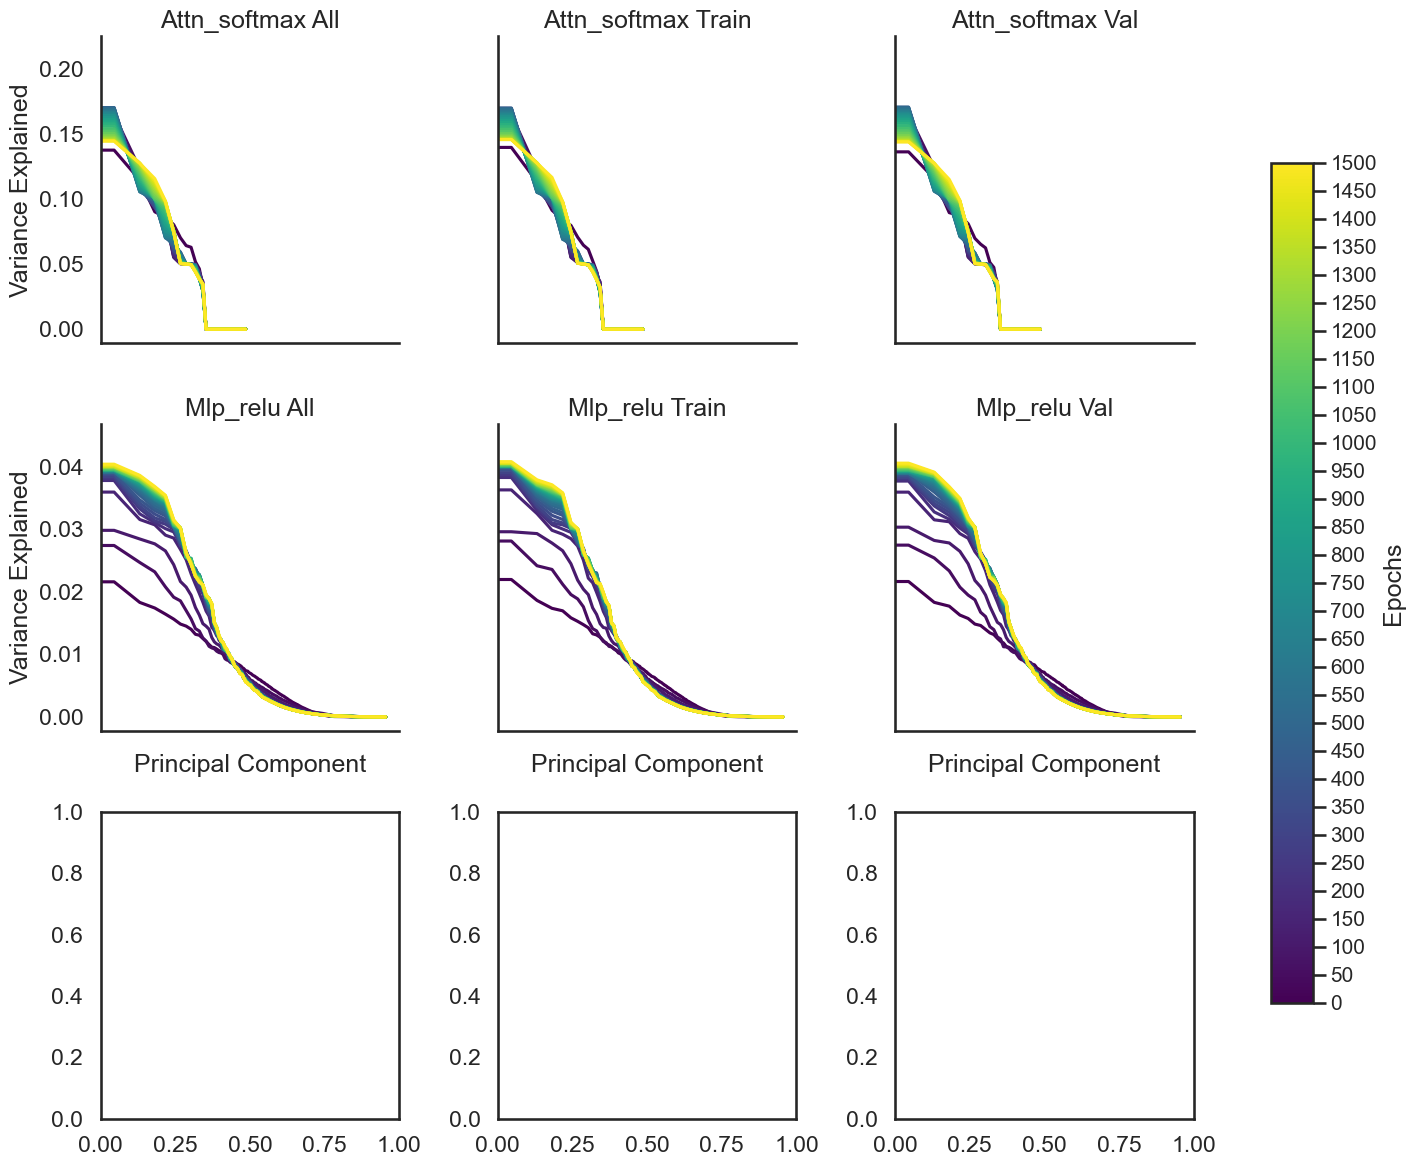

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def plot_variance_explained(var_expl: Dict[str, Dict[str, np.ndarray]], model_parts: list, trial_types: list, epochs: list):
    fig, axs = plt.subplots(3, 3, figsize=(14, 12))

    for i, mp in enumerate(model_parts):
        for j, trial_type in enumerate(trial_types):
            ax = axs[i, j]
            ax.set_xscale('log')

            # Share y-axis within a row
            if j > 0:
                axs[i, j].get_shared_y_axes().join(axs[i, j], axs[i, 0])
                ax.set_yticklabels([])

            if i < 2:
                ax.set_xticklabels([])

            # Share x-axis within a column
            if i > 0:
                axs[i, j].get_shared_x_axes().join(axs[i, j], axs[0, j])

            # some options for colors are 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
            colors = plt.cm.viridis(np.linspace(0,1, len(epochs)))

            for k, epoch in enumerate(epochs):
                ax.plot(var_expl[trial_type][mp][epoch], color=colors[k])
       

            ax.set_title(f'{mp.capitalize()} {trial_type.capitalize()}')

            # Set x and y labels for subplots bordering the left and bottom
            if i == len(model_parts) - 1:
                ax.set_xlabel('Principal Component')
            if j == 0:
                ax.set_ylabel('Variance Explained')

            # turn boxx off
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # add some ticks to x axis


    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
    norm = Normalize(vmin=0, vmax=len(epochs) - 1)
    cbar = ColorbarBase(cbar_ax, cmap=plt.cm.viridis, norm=norm, ticks=range(len(epochs)), orientation='vertical')
    cbar.ax.set_yticklabels([str(epoch) for epoch in epochs], fontsize='small')
    cbar.ax.set_ylabel('Epochs', fontsize='medium')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


plot_variance_explained(var_expl, model_part.keys(), trial_types, epochs)


Some things to note:
1. There seems to be very little difference between any of the columns of this plot, meaning that the geometry of the activations is similar for the training and validation data. So, we can't explain the difference in performance between the training and validation data by saying that the geometry of the activations is different, at least within these modules of the transformer.
2. Focussing on the first row, which gives the variance explained over the PCs for the embedding layer, we see that over training the activations are pushed to a smaller-dimensional linear manifold. 
3. This also occurs for the attention autput and mlp output, but the dynamics seem a bit different. Let's explore the dynamics in the next plot.

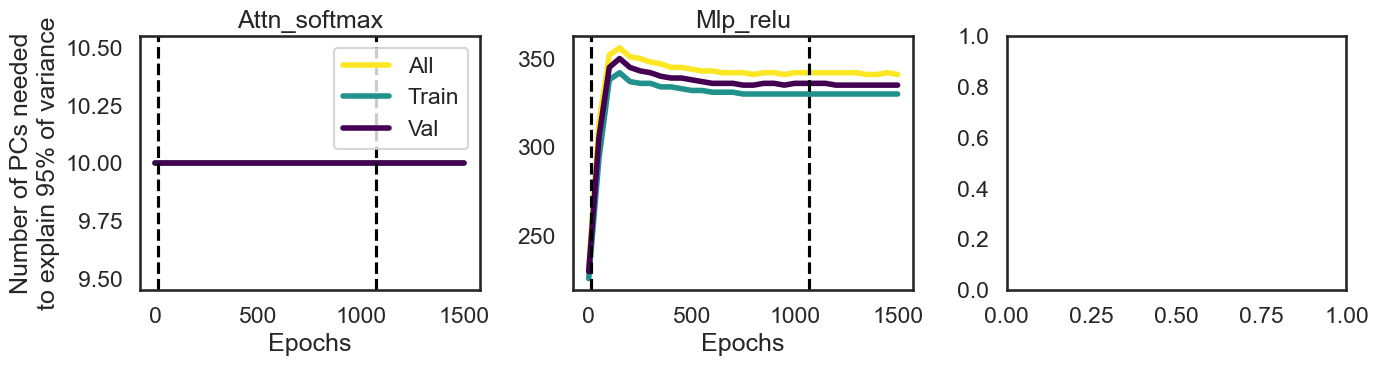

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_pcs_to_explain_95(var_expl: Dict[str, Dict[str, np.ndarray]], model_parts: list, trial_types: list, epochs: list):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    # Custom colormap for trial types
    trial_type_cmap = ListedColormap(plt.cm.viridis(np.linspace(1,0, len(trial_types))))
    
    for i, mp in enumerate(model_parts):
        ax = axs[i]
        
        for j, trial_type in enumerate(trial_types):
            n_pcs = []
            for epoch in epochs:
                n_pcs.append(np.where(np.cumsum(var_expl[trial_type][mp][epoch]) > 0.95)[0][0])
            ax.plot(epochs, n_pcs, color=trial_type_cmap(j), label=trial_type.capitalize(), lw=4)
        
        ax.set_title(mp.capitalize())
        ax.set_xlabel('Epochs')
        

        # plot a vertical line at the memorization epoch and the grokking epoch
        ax.axvline(x=mem_acc_epoch, color='black', linestyle='--')
        ax.axvline(x=grok_acc_epoch, color='black', linestyle='--')
        
        if i == 0:
            # Add legend only to the first subplot
            ax.legend()
            ax.set_ylabel('Number of PCs needed\nto explain 95% of variance')

    plt.tight_layout()
    plt.show()

plot_pcs_to_explain_95(var_expl, model_part.keys(), trial_types, epochs)


The first thing to note is the sharp dip in dimensionality early on in training for the ATtn_out and MLP_out layers. This suggests (but doesn't prove) that this restrictin of dimensionality is associated with  memorization of the training data. Interestingly, both the attention and mlp modules quickly organize their activations to spread across more dimensions, but the memorization of the training data does not change. This reminds me of neural work in the motor cortex showing that the cortex often puts computation that is important for preparing for motor commands (e.g. deciding which command to take) into a nullspace of the computation that is important for carrying out the motor command. Could this increase in dimensionality early on be the activity of the network moving around trying to find a generalization, but not wanting to sacrifice its accuracy on the training data?

If we don't consider the very early dips and rising in these plots, then the other thing I notice here is that the Attention Output and MLp OUtput modules become dimensionaly restricted earlier than the embedding layer, e.g. by 500 trials most of the restriction has occured, whereas for the embedding layer, most of the restriction happans after 500.



# Let's actually look at some activations!

It's always a good idea to simply look at your data. Let's take a step back and do some exploratory type stuff on the activations.

In [304]:
n_epochs = len(W_E.keys())
n_modules = len(model_part.keys())

# Get the number of trials and maximum number of neurons for preallocation
n_trials, _ = get_acts_for_epoch_and_module(W_E, next(iter(W_E.keys())), model_part[next(iter(model_part.keys()))]).shape
max_neurons = max(get_acts_for_epoch_and_module(W_E, next(iter(W_E.keys())), model_part[module]).shape[1] for module in model_part.keys())
print(f'Number of epochs: {n_epochs}')
print(f'Number of trials: {n_trials}')
print(f'Maximum number of neurons: {max_neurons}')

# Preallocate the DataFrame
columns = pd.MultiIndex.from_product([list(model_part.keys()), range(max_neurons), range(n_trials)], names=['module', 'neuron', 'trial'])
all_data = pd.DataFrame(index=pd.Index(range(n_epochs), name='epoch'), columns=columns)

# Sort the MultiIndex
all_data.sort_index(axis=1, inplace=True)

# Populate the DataFrame
for epoch in W_E.keys():
    for module in model_part.keys():
        print(f'Epoch {epoch}, module {module}')
        activations = get_acts_for_epoch_and_module(W_E, epoch, model_part[module])
        n_neurons = activations.shape[1]
        
        # Update the DataFrame in-place
        all_data.loc[epoch, (module, slice(0, n_neurons))] = activations.T.flatten()

# Reset the columns to a simpler format if desired
all_data.columns = all_data.columns.map('_'.join)


Number of epochs: 31
Number of trials: 12769
Maximum number of neurons: 384
Epoch 0, module embed
Epoch 0, module attn_out
Epoch 0, module mlp_out
Epoch 50, module embed
Epoch 50, module attn_out
Epoch 50, module mlp_out
Epoch 100, module embed
Epoch 100, module attn_out
Epoch 100, module mlp_out
Epoch 150, module embed
Epoch 150, module attn_out
Epoch 150, module mlp_out


KeyboardInterrupt: 

In [297]:
def get_acts_for_epoch_and_module(W_E, epoch, module):
    activations = W_E[epoch][module].tensor_contents # (batch_size, seq_len, hidden_size)
    trials, input_size, d_model = activations.shape
    n_neurons = input_size * d_model
    activations = activations.reshape(trials, n_neurons)
    return activations

model_part = {'embed': 'add_1_9', 'attn_out': 'cat_1_50', 'mlp_out': 'linear_18_54'}

# let's make a dataframe with the activations of all neurons for all epochs for all modules
# we want to initialize columns of the dataframe with the epoch, module, and neuron, and activation
all_data = []
for epoch in W_E.keys():
    for module in model_part.keys():
        activations = get_acts_for_epoch_and_module(W_E, epoch, model_part[module])
        # activations is a numpy array of shape (trials, n_neurons)
        
        trials, n_neurons = activations.shape
        
        # Create indices for epoch, module, neuron, and trial
        epoch_idx = [epoch] * trials * n_neurons
        module_idx = [module] * trials * n_neurons
        neuron_idx = (np.arange(n_neurons) % n_neurons).tolist() * trials
        trial_idx = np.repeat(np.arange(trials), n_neurons).tolist()
        
        # Flatten the activations
        flat_activations = activations.flatten().tolist()
        
        # Create a new dataframe with the current data
        current_data = pd.DataFrame({
            'epoch': epoch_idx,
            'module': module_idx,
            'neuron': neuron_idx,
            'trial': trial_idx,
            'activation': flat_activations
        })
        
        # Append the current data to the all_data dataframe
        all_data.append(current_data)

all_data = pd.concat(all_data, axis=0)


epochs = [50, 750, 1500]
module = model_part['attn_out']

full_df = pd.DataFrame()
for e in epochs:
    activations = get_acts_for_epoch_and_module(W_E, e, module)
    # choose some random neuron indices
    # put the data into a pandas df so that we can plot histograms of the activations
    df = pd.DataFrame(activations, columns=[f'neuron_{i}' for i in range(activations.shape[1])])
    df = df.melt(var_name='neuron', value_name='activation')
    df['epoch'] = e
    full_df = pd.concat([full_df, df], axis=0)

# choose random neurons, by querying a random set of values of the neuron column
# get all possible values of the neuron column
neuron_indices = full_df['neuron'].unique()
# choose some random neuron indices
neuron_indices = np.random.choice(neuron_indices, size=20, replace=False)
full_df = full_df.query('neuron in @neuron_indices')

# Set seaborn style and context
sns.set_style('white')
sns.set_context('talk')

# Create a FacetGrid for the histograms of the activations
g = sns.FacetGrid(full_df, col='neuron', col_wrap=5, sharex=False, sharey=False, hue='epoch')
# make these densities
g.map(sns.histplot, 'activation', kde=True, bins=10, alpha=0.8, stat='density')

# Improve aesthetics
g.set_axis_labels("Activation", "Density")
g.set_titles("Neuron {col_name}")
g.despine(left=False, bottom=False)

plt.show()


KeyboardInterrupt: 

In [ ]:
all_data

384


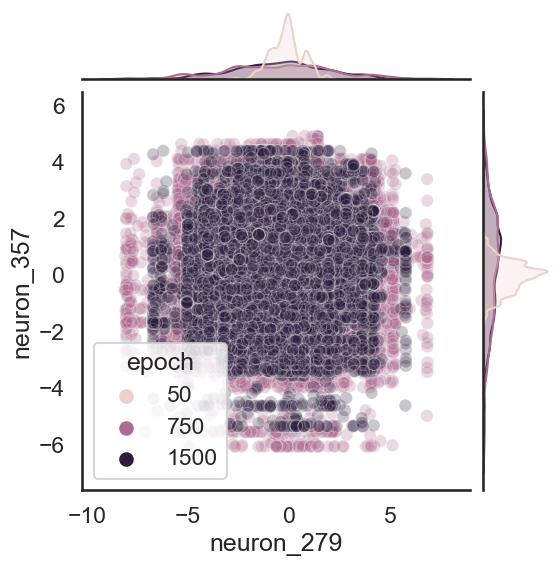

In [291]:
def get_acts_for_epoch_and_module(W_E, epoch, module):
    activations = W_E[epoch][module].tensor_contents # (batch_size, seq_len, hidden_size)
    trials, input_size, d_model = activations.shape
    n_neurons = input_size * d_model
    activations = activations.reshape(trials, n_neurons)
    return activations

model_part = {'embed': 'add_1_9', 'attn_out': 'cat_1_50', 'mlp_out': 'linear_18_54'}

epochs = [50, 750, 1500]
module = model_part['attn_out']

full_df = pd.DataFrame()
for e in epochs:
    activations = get_acts_for_epoch_and_module(W_E, e, module)
    # choose some random neuron indices
    # put the data into a pandas df so that we can plot histograms of the activations
    df = pd.DataFrame(activations, columns=[f'neuron_{i}' for i in range(activations.shape[1])])
    df = df.melt(var_name='neuron', value_name='activation')
    df['epoch'] = e
    full_df = pd.concat([full_df, df], axis=0)

# choose random neurons, by querying a random set of values of the neuron column
# get all possible values of the neuron column
neuron_indices = full_df['neuron'].unique()

# lets pick 2 neurons and then plot a 2d histogram of their activations
neuron_indices = full_df['neuron'].unique()

# choose some random neuron indices, but make sure that the standard deviation of the activations is not too small when 
# groupedby neuron, and epoch
# compute the standard deviation of the activations for each neuron and epoch
stds = full_df.groupby(['epoch', 'neuron']).std().reset_index()
# choose all neurons that have a standard deviation of the activations > 0 at least once
neuron_indices = stds.query('activation > 0')['neuron'].unique()
print(len(neuron_indices))
# choose 2 neurons
neuron_indices = np.random.choice(neuron_indices, size=2, replace=False)
full_df_ = full_df.query('neuron in @neuron_indices').reset_index()

# Create a new column to store the unique trial identifiers
full_df_['trial'] = full_df_.groupby(['epoch', 'neuron']).cumcount()

# Set seaborn style and context
sns.set_style('white')
sns.set_context('talk')

# get the 2 values of the neuron column
neuron_0, neuron_1 = full_df_['neuron'].unique()

# make the df have columns act_nrn0, act_nrn1, epoch, trial
full_df_ = full_df_.pivot_table(index=['epoch', 'trial'], columns='neuron', values='activation').reset_index()

# Plot the 2D histogram
sns.jointplot(data=full_df_, x=neuron_0, y=neuron_1, alpha=0.25, hue='epoch')


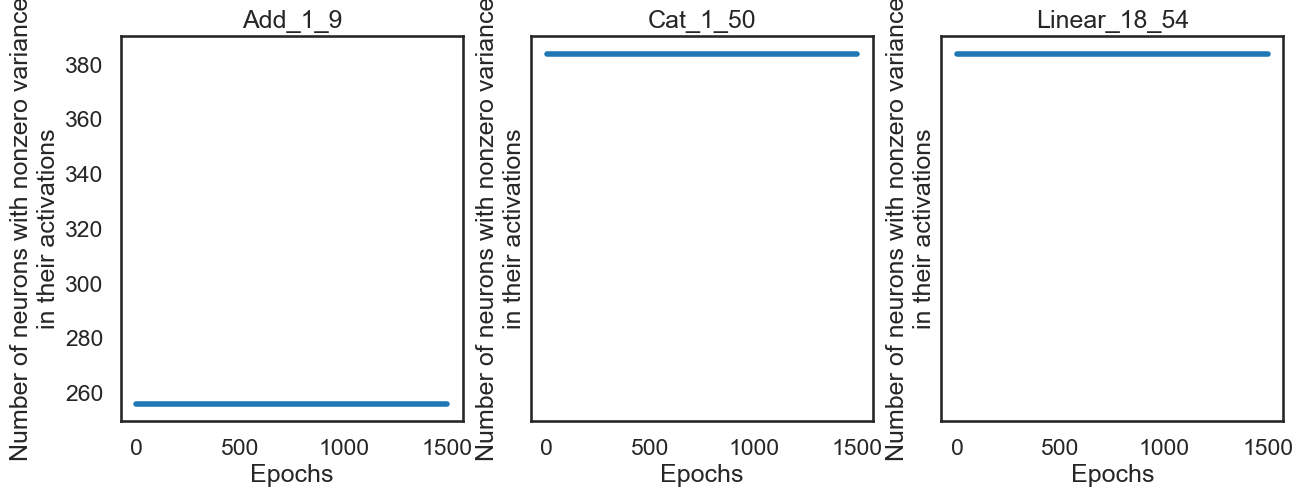

In [286]:
# for each model part, and each epoch, how many neurons have nonzero variance in their acivations?

def get_n_neurons_with_nonzero_var(W_E, model_parts, epochs):
    n_neurons = {}
    for mp in model_parts:
        n_neurons[mp] = {}
        for e in epochs:
            activations = W_E[e][mp].tensor_contents
            activations = activations.reshape(activations.shape[0], -1) # (trials, n_neurons)
            var = np.var(activations.numpy(), axis=0) # (n_neurons,)
            n_neurons[mp][e] = np.sum(var > 1e-3)
    return n_neurons
model_parts = list(model_part.values())
epochs = list(W_E.keys())

n_neurons = get_n_neurons_with_nonzero_var(W_E, model_parts, epochs)

# plot the number of neurons with nonzero variance in their activations
fig, axs = plt.subplots(1, len(model_parts), figsize=(15, 5), sharey=True)
for i, mp in enumerate(model_parts):
    ax = axs[i]
    ax.plot(epochs, list(n_neurons[mp].values()), lw=4)
    ax.set_title(mp.capitalize())
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Number of neurons with nonzero variance\nin their activations')



In [179]:
def get_acts_for_epoch_and_module(W_E, epoch, module):
    activations = W_E[epoch][module].tensor_contents # (batch_size, seq_len, hidden_size)
    trials, input_size, d_model = activations.shape
    n_neurons = input_size * d_model
    activations = activations.reshape(trials, n_neurons)
    return activations

epochs = [0, 750, 1500]
module = 'add_1_9'

full_df = pd.DataFrame()
for e in epochs:
    activations = get_acts_for_epoch_and_module(W_E, e, module)
    # choose some random neuron indices
    # put the data into a pandas df so that we can plot histograms of the activations
    df = pd.DataFrame(activations, columns=[f'neuron_{i}' for i in range(activations.shape[1])])
    df = df.melt(var_name='neuron', value_name='activation')
    df['epoch'] = e
    full_df = pd.concat([full_df, df], axis=0)

# choose random neurons, by querying a random set of values of the neuron column
# get all possible values of the neuron column
neuron_indices = full_df['neuron'].unique()

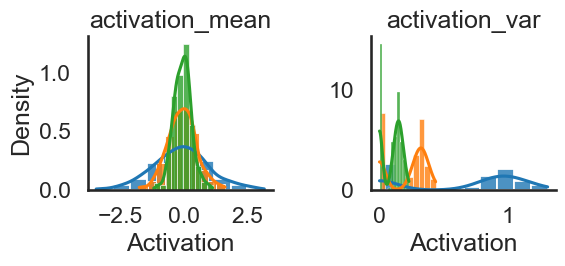

In [187]:
# use groupby to get the mean activation for each neuron at each epoch, and variance
mean_df = full_df.groupby(['epoch', 'neuron']).mean().reset_index()
var_df = full_df.groupby(['epoch', 'neuron']).var().reset_index()
# make a df with the mean and variance for each neuron at each epoch    
mean_var_df = mean_df.merge(var_df, on=['epoch', 'neuron'], suffixes=('_mean', '_var'))

# plot histograms of the means and variances
# change the mean_var_df so that it has a column called type and its value can be either 'mean' or 'var'
mean_var_df = mean_var_df.melt(id_vars=['epoch', 'neuron'], value_vars=['activation_mean', 'activation_var'], var_name='type', value_name='activation')
# now use seaborn to plot the histograms for the mean and variance, one in each column, with hue=epoch
g = sns.FacetGrid(mean_var_df, col='type', col_wrap=2, sharex=False, sharey=False, hue='epoch')
g.map(sns.histplot, 'activation', kde=True, bins=10, alpha=0.8, stat='density')

# Improve aesthetics
g.set_axis_labels("Activation", "Density")
g.set_titles("{col_name}")
g.despine(left=False, bottom=False)

plt.show()



384

In [188]:
mean_var_df

,epoch,neuron,type,activation
0,0,neuron_0,activation_mean,-0.796780
1,0,neuron_1,activation_mean,1.313237
2,0,neuron_10,activation_mean,-1.365905
3,0,neuron_100,activation_mean,-1.672850
4,0,neuron_101,activation_mean,-1.429156
...,...,...,...,...
2299,1500,neuron_95,activation_var,0.156804
2300,1500,neuron_96,activation_var,0.158079
2301,1500,neuron_97,activation_var,0.172179
2302,1500,neuron_98,activation_var,0.228685


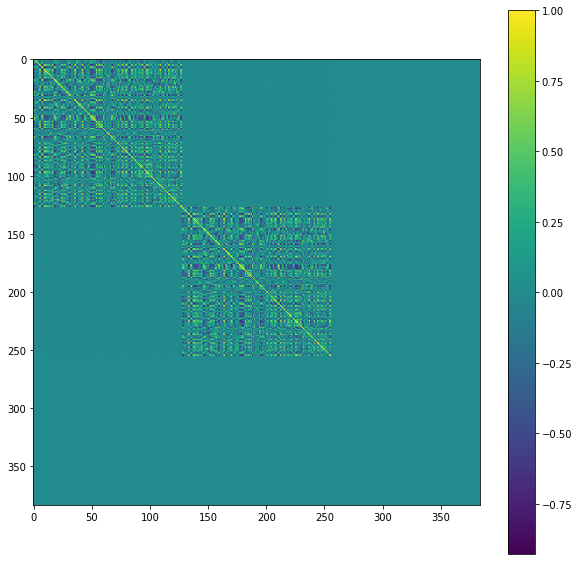

In [ ]:
import numpy as np
# now calculate the covariance matrix
cov_mat = np.cov(embedding_acts.T)
# replace 0 with Nan
# plot the correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(cov_mat)
plt.colorbar()


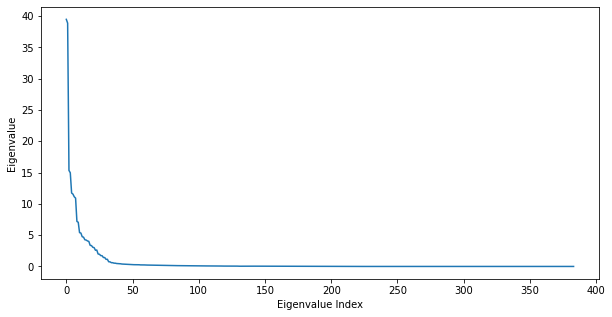

In [ ]:
# plot the eigenspectrum of the covariance matrix
plt.figure(figsize=(10, 5))
plt.plot(np.linalg.eigvals(cov_mat))
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.show()

Text(0, 0.5, 'Variance Explained')

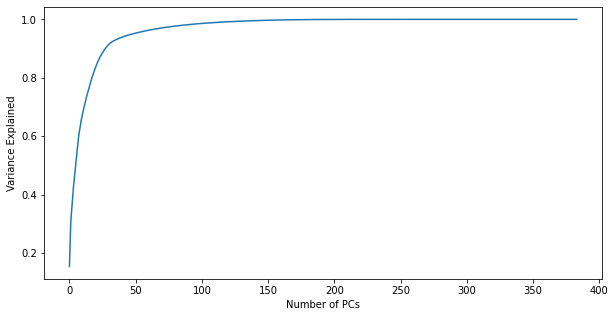

In [ ]:
# plot variance explained by PC
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(np.linalg.eigvals(cov_mat))/np.sum(np.linalg.eigvals(cov_mat)))
plt.xlabel("Number of PCs")
plt.ylabel("Variance Explained")